In [534]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 
import time

In [558]:
# sampling x 
x1 = np.random.normal(3 , 2, (1000000,) ) 
x2 = np.random.normal(-1, 2 , (1000000,)) 
x = np.zeros((1000000, 3)) 

x[:, 0] = 1 # adding intercept term 
x[:, 1] = x1 
x[:, 2] = x2 
# print(np.var(x[:, 1]))  

# sampling y 

original_hypothesis = np.array([3,1,2]) 
y = np.matmul(x, original_hypothesis) 
y += np.random.normal(0, math.sqrt(2) , y.shape)  
# print(np.mean(y)) 



In [516]:
def compute_batch_error(X, Y, theta, batch_size, batch_number):
    X_batch = X[batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size, :] 
    Y_batch = Y[ batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size] 

    Z = Y_batch - np.matmul(X_batch, theta)
    error = np.matmul(np.transpose(Z), Z) / (2 * batch_size) 
    return error  

In [517]:
def compute_batch_gradient(X, Y, theta, batch_size, batch_number):
    X_batch = X[batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size, :] 
    Y_batch = Y[ batch_size  * (batch_number - 1)   : batch_size * (batch_number - 1) + batch_size] 
    Z_batch = Y_batch - np.matmul(X_batch, theta) 
    # print(Z)
    gradient = np.zeros(theta.size) 
    for j in range(theta.size):
        X_j = X_batch[:, j] 
        gradient[j] = np.sum(Z_batch * X_j)/ batch_size 
    return gradient

In [566]:
def compute_error(X, Y, hypothesis):
    Z = (Y - np.matmul(X, hypothesis)) 
    m = Y.size 
    error = np.matmul(np.transpose(Z), Z)/ (2 * m) 
    return error 

arr = np.array([ [1,2,3], [3,4,5], [5,6,10]]) 
np.random.shuffle(arr) 
print(arr) 

[[ 5  6 10]
 [ 3  4  5]
 [ 1  2  3]]


In [519]:
def minibatch_gradient_descent(X, Y, batch_size, k, gamma):
    current_batch_number = 1 
    theta = np.zeros(X[0].size) 
    # print(theta) 
    initial_error = compute_batch_error(X, Y, theta,  batch_size, int(current_batch_number) ) 
    epsilon = 0.000001 * initial_error 
    # epsilon = 1e-5
    # print(f"factor is {pow(batch_size, -0.5)}")
    #we decrease epsilon for large batch sizes, since smaller batch sizes converge more noisily to the 
    # optima, thus they require a larger epsilon 
     
    epsilon = pow(batch_size, -0.5) * epsilon 
    max_count = int(1/epsilon) 
    # to avoid oscillations, we introduce this cap  


    learning_parameter = 0.001
    MOD = Y.size / batch_size 
    max_count = max(max_count, MOD)  
    print(f"maxcount is {max_count}")
    no_of_iterations = 0 


    error_arr = []
    running_avg = 0 
    previous_running_avg = 0 

    for i in range(k):
        grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
        theta = theta + learning_parameter * grad 
        # curr_error = compute_batch_error(X, Y,theta,  batch_size, int(current_batch_number) )
        curr_error = compute_error(X, Y, theta) 
        error_arr.append(curr_error) 
        running_avg += curr_error 
        current_batch_number = (current_batch_number + 1) 
        if (current_batch_number > MOD):  current_batch_number -= MOD 
        # no_of_iterations += 1


    running_avg /= k
    last_count = 0  # no of consecutive times difference in averages is less than epsilon  
    # epsilon = 0.000001 * running_avg 
    
    while (last_count < gamma and no_of_iterations < max_count):
        
        
        previous_running_avg = running_avg 
        previous_error = error_arr.pop(0) 

        # print(f" batch size, batch num {batch_size} {current_batch_number}") 
        grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
        theta = theta + learning_parameter * grad 
        
        # curr_error = compute_batch_error(X, Y,theta,  batch_size, int(current_batch_number) ) 
        curr_error = compute_error(X, Y, theta)
        error_arr.append(curr_error) 

        running_avg = running_avg + (curr_error - previous_error)/k  

        # print(f"current theta is {theta}") 
        # print(f"last count {last_count}")
        # print(f"average error is {running_avg}") 
        
        if (abs(previous_running_avg - running_avg) < epsilon) :  last_count += 1 
        else: last_count = 0
        
        no_of_iterations += 1 
        current_batch_number = (current_batch_number + 1) 
        if (current_batch_number > MOD):  current_batch_number -= MOD 

    print(f"no of iterations is {no_of_iterations}") 
    # print(f"learned theta is {theta}") 
    return theta 
    

In [571]:
def minibatch_v2(X, Y, batch_size, k, gamma, epsilon):
    Z = np.zeros((Y.shape[0], X.shape[1] + 1)) 
    for i in range(X.shape[1]):
        Z[:, i] = X[:, i] 
    Z[:, X.shape[1]] = Y 
    np.random.shuffle(Z) 

    X = Z[:, 0:3] 
    Y = Z[:, 3]   
    # here i compute difference of two consecutive sets of k iterations 
    current_batch_number = 1  
    theta = np.zeros(X[0].size) 
    initial_error = compute_error(X, Y, theta) 
    # epsilon = 0.000001 * initial_error  
    # epsilon = 1e-6 if (batch_size > int(math.sqrt(Y.size))) else 5e-5 
    
    # print(f"epsilon is {epsilon}")
    #we decrease epsilon for large batch sizes, since smaller batch sizes converge more noisily to the 
    # optima, thus they require a larger epsilon 
    
    learning_parameter = 0.001
    MOD = Y.size / batch_size 
    no_of_iterations = 0 

    previous_avg_error = 0 
    avg_error = 0 
    last_count = 0 
    
    max_count = max(1e4, 100 * MOD) 
    point_list = [] 
    print(max_count) 
    while (True):
        previous_avg_error = avg_error 
        avg_error = 0 
        for i in range(k):
            grad = compute_batch_gradient(X, Y, theta, batch_size, int(current_batch_number) ) 
            theta = theta + learning_parameter * grad  
            point_list.append(theta) 
            curr_error = compute_batch_error(X, Y, theta, batch_size, int(current_batch_number))  
            avg_error += curr_error 
            no_of_iterations += 1 
            current_batch_number = (current_batch_number + 1) 
            if (current_batch_number > MOD):  current_batch_number -= MOD 
        avg_error /= k         
        # print(f"theta : {theta}") 
        # print(f"avg_error last_count {avg_error} {last_count} ")
        if (abs(avg_error - previous_avg_error) <  epsilon): last_count += 1 
        else : last_count = 0 
        if (last_count >= gamma or no_of_iterations > max_count): break 
    
    print(f"no of iterations is {no_of_iterations}") 
    print(f"learned theta is {theta}") 
    return (theta, point_list)
    

In [579]:
test_set = pd.read_csv("./ass1_data/data/q2/q2test.csv") 
test_set = test_set.to_numpy() 
temp = np.zeros((10000, 4)) 
temp[:,0] = 1 
temp[:, 1] = test_set[:, 0] 
temp[:, 2] = test_set[:, 1] 
temp[:, 3] = test_set[:, 2]

test_set = temp 

# print(test_set) 

test_input = test_set[:, 0 : 3] 
test_output = test_set[:, 3] 

start1 = time.time() 
(model1, list1) = minibatch_v2(x, y, 1, 10, 1, 1e-4) 
error1 = compute_error(test_input, test_output, model1) 
print(f"model1  error1  {model1}  | {error1}")
end1 = time.time() 
print(f"time taken is {end1 - start1}s\n") 


start2 = time.time() 
(model2, list2) = minibatch_v2(x, y, 100, 40 , 1, 8e-5) 
error2 = compute_error(test_input, test_output, model2) 
print(f"model2  error2  {model2}  | {error2}")
end2 = time.time() 
print(f"time taken is {end2 - start2}s\n") 


start3 = time.time() 

(model3, list3) = minibatch_v2(x, y, 10000, 10 ,1, 1e-6) 
error3 = compute_error(test_input, test_output, model3) 
print(f"model3  error3  {model3}  | {error3}")
end3 = time.time() 
print(f"time taken is {end3 - start3}s\n") 


start4 = time.time() 

(model4, list4) = minibatch_v2(x, y, 1000000, 1, 1, 1e-6) 
error4 = compute_error(test_input, test_output, model4) 
print(f"model4  error4  {model4}  | {error4}")
end4 = time.time() 
print(f"time taken is {end4 - start4}s\n") 


100000000.0
no of iterations is 23480
learned theta is [3.00344361 1.01897823 2.07416731]
model1  error1  [3.00344361 1.01897823 2.07416731]  | 1.2674999821741697
time taken is 2.0542213916778564s

1000000.0
no of iterations is 20120
learned theta is [2.98829699 1.00528937 1.99466572]
model2  error2  [2.98829699 1.00528937 1.99466572]  | 0.9862698959155026
time taken is 2.0013809204101562s

10000.0
no of iterations is 10010
learned theta is [2.81854986 1.03969203 1.98632129]
model3  error3  [2.81854986 1.03969203 1.98632129]  | 1.0791584046458575
time taken is 3.3118484020233154s

10000.0
no of iterations is 10001
learned theta is [2.81808699 1.03960793 1.98621546]
model4  error4  [2.81808699 1.03960793 1.98621546]  | 1.0790488806251932
time taken is 390.5670256614685s



In [580]:


og_error1 = compute_error(test_input, test_output, original_hypothesis) 
print(error1, error2, error3, error4, model1, model2, model3, model4) 
print("error wrt original model") 
print(og_error1) 


1.2674999821741697 0.9862698959155026 1.0791584046458575 1.0790488806251932 [3.00344361 1.01897823 2.07416731] [2.98829699 1.00528937 1.99466572] [2.81854986 1.03969203 1.98632129] [2.81808699 1.03960793 1.98621546]
error wrt original model
0.9829469215


In [529]:
def plot_theta_movement(plot_list):
    plot_list = np.array(plot_list) 
    x = plot_list[:,0] 
    y = plot_list[:, 1] 
    z = plot_list[:, 2] 
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z) 

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z') 

    ax.set_title('Movement of Theta') 
    plt.show()


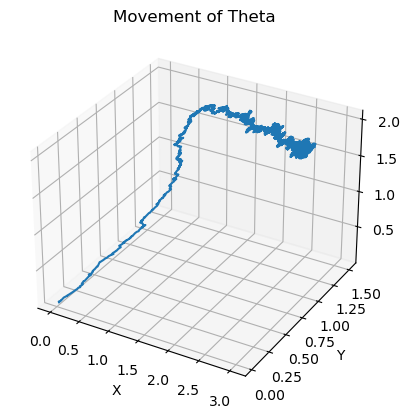

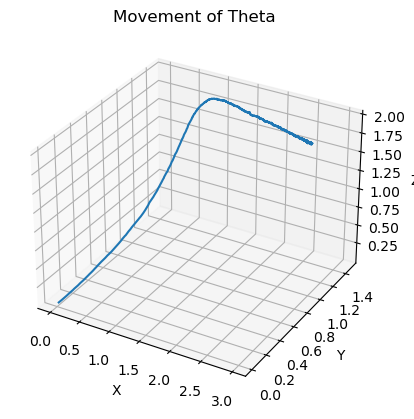

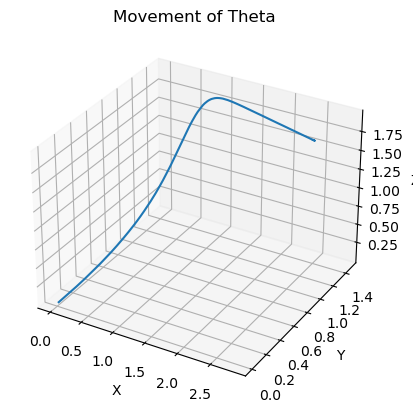

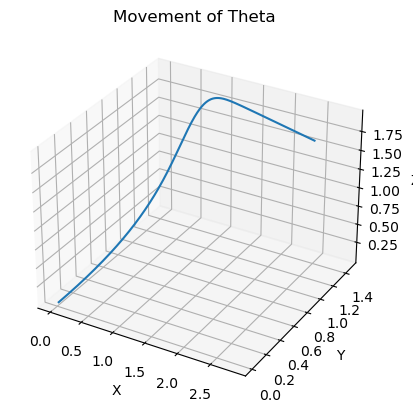

In [581]:
plot_theta_movement(list1)
plot_theta_movement(list2)
plot_theta_movement(list3)
plot_theta_movement(list4)

## Comments- 
1. We observe that the different algorithms converge to observably different values of theta, depending on the convergence criteria, and the batch size.  
2. The relative difference between the learned parameters and the original hypothesis, are 
 (% diff between thetas) 
3. We observe that the no of iterations taken decreases as we increase the batch size, although the total time taken increases with increasing batch size. This can be rationalised by the following argument-
    The noise in the trajectory of theta is more for less batch sizes, thus they require more iterations to converge, however as the time needed for one iteration is also less for small batch sizes (one iteration means updating parameters using 1 batch), the overall time decreases with increasing batch size. Thus the speed of convergence is more for smaller batch sizes, as time taken is less to converge and the parameters update more frequently, but the no of iterations is also more for the smaller batch sizes. 

